In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

You should consider upgrading via the 'C:\Users\christian\Documents\christian\work\python\cyberspace\topic_modeler\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [7]:
datasize = 50
min_document_length = 512
max_document_length = 1024


index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [8]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index][:512]}")

Topic: rec.autos
hello i be look to slightly increase the performance of my 89 honda civic si i be wonder if anyone could suggest upgrade that be not too drastic i thought that one of the easy upgrade would be a new header do anyone know what kind of increase that the header would give me i think i would check with jackson race for the part be there any other comparines would make honda part be there any other small change that can be easily make and won t screw up the car thing like new injector new fuel injection chip etc


In [9]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


In [10]:
print(f"there are {len(train_docs)} docs")

there are 200 docs


### Initialize Vectorizer

In [11]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 4476


### Prepare Datatset

In [12]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

200 train_docs


### Word-Word Ratio

In [13]:
def plot_word_word_co():
    random_plot = False


    word = "pilot"
    words = ["the", "religion", "car", "and", "driver", "shuttle"]

    if random_plot:
        words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
        word = words[0]

    fig = plt.figure(figsize=(15,5), tight_layout=True)
    ax11 = fig.add_subplot(131)
    ax12 = fig.add_subplot(132)
    ax13 = fig.add_subplot(133)

    ax11.set_title(f"{word} against WORDS relation")
    ax11.bar(words, word_word_co.loc[word][words])

    ax12.set_title(f"WORDS against {word} relation")
    ax12.bar(words, (word_word_co * word_word_co.T).loc[word][words])

    pxy = word_doc_frequency_norm[word_doc_frequency_norm[word] > 0].sum(0)
    pxy /= total_num_of_documents

    ax13.set_title(f"{word} against Words Frequency")
    ax13.bar(words, pxy[words])

    plt.show()

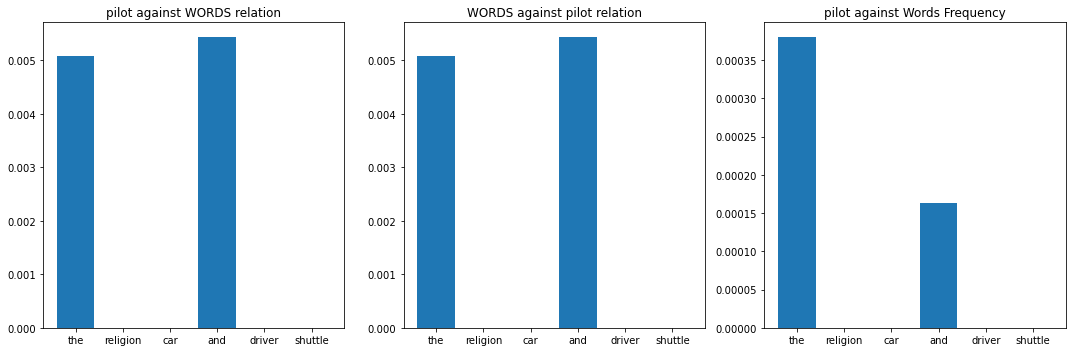

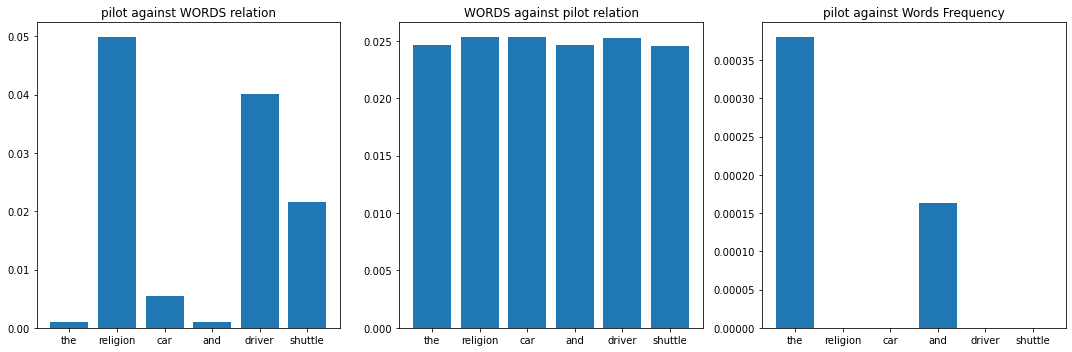

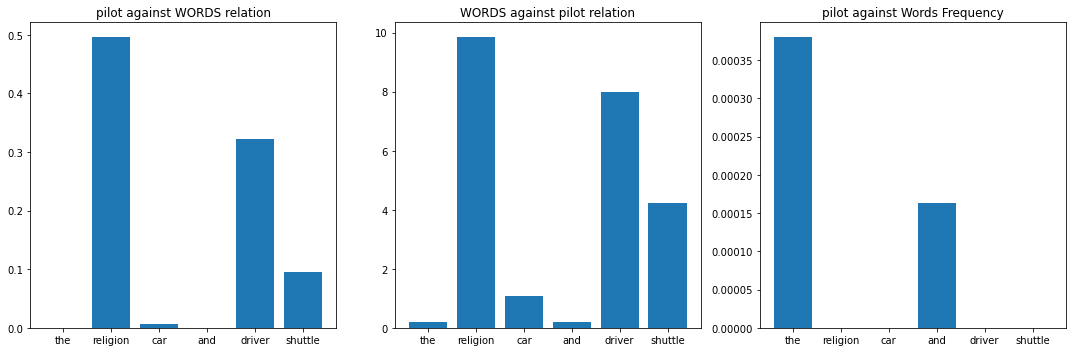

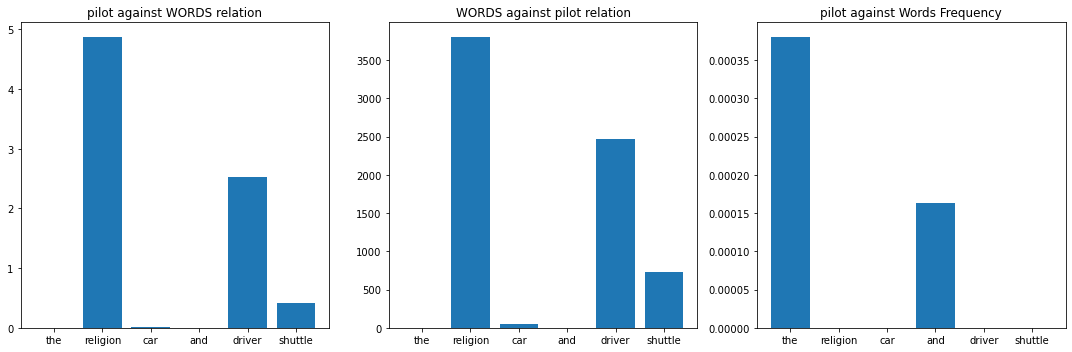

In [ ]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

# wdf = word_doc_frequency_norm.copy()
wdf = (word_doc_frequency_norm > 0).astype(int)

probability = wdf.mean(0)
doc_word_distr = wdf.copy()

n_iter = 0
number_of_iterations = 8
total_number_of_iterations = (len(vocabulary) + total_num_of_documents) * number_of_iterations

with tqdm(total=total_number_of_iterations) as pbar:
    while n_iter < number_of_iterations:
        n_iter += 1

        word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
        doc_word_distr = doc_word_distr.T

        for word in (vocabulary):
            wwcr = (doc_word_distr * doc_word_distr.loc[word]).sum(1) / doc_word_distr.loc[word].sum()
            word_word_co.loc[word] = wwcr * (probability[word] / probability)
            pbar.update(1)

#         doc_word_distr = doc_word_distr.T
        plot_word_word_co()
        doc_word_distr = wdf.copy()

        for doc_index in (range(total_num_of_documents)):
            words = doc_word_distr.columns[doc_word_distr.loc[doc_index] > 0]
            doc_word_distr.loc[doc_index] = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T.mean(0)
            pbar.update(1)
            
#         doc_word_distr /= doc_word_distr.max().max()

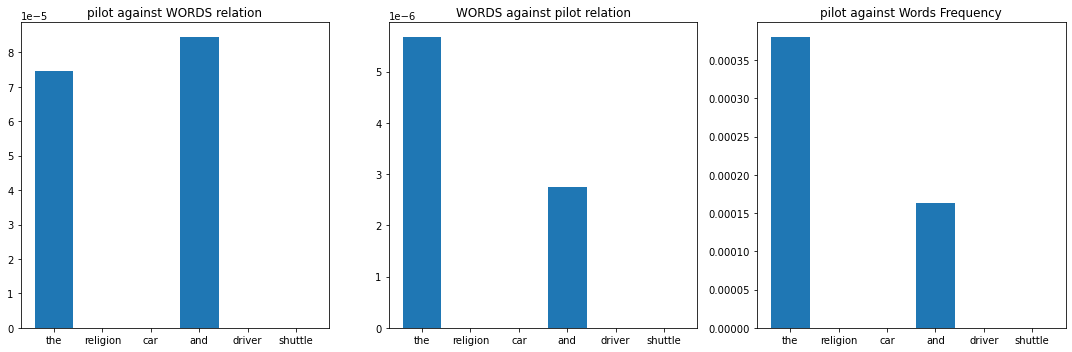

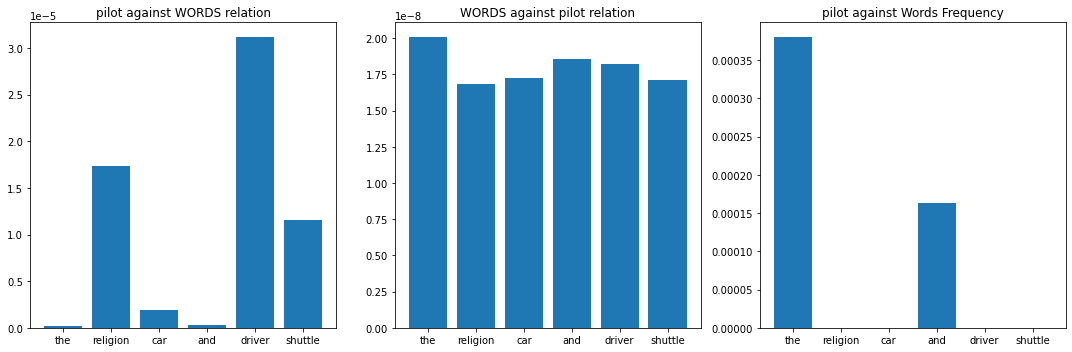

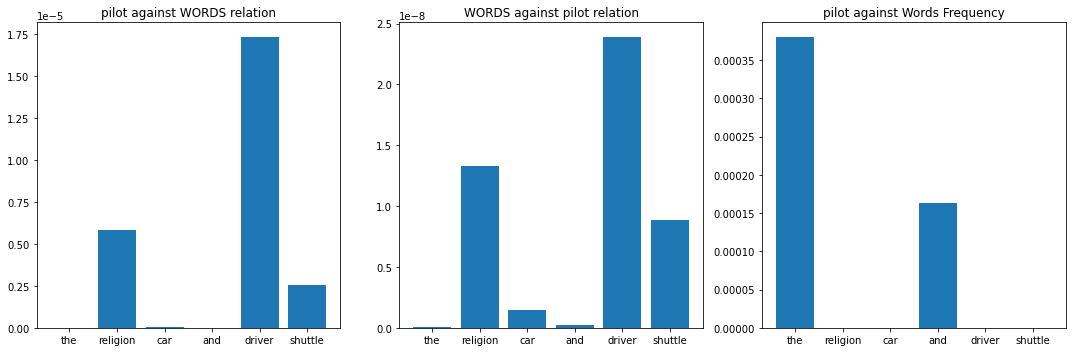

In [15]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

wdf = word_doc_frequency_norm.copy()

probability = wdf.mean(0)
doc_word_distr = wdf.copy()

n_iter = 0
number_of_iterations = 8
total_number_of_iterations = (len(vocabulary) + total_num_of_documents) * number_of_iterations

with tqdm(total=total_number_of_iterations) as pbar:
    while n_iter < number_of_iterations:
        n_iter += 1

        word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
        doc_word_distr = doc_word_distr.T

        for word in (vocabulary):
            wwcr = (doc_word_distr * doc_word_distr.loc[word]).sum(1) / doc_word_distr.loc[word].sum()
            word_word_co.loc[word] = wwcr * (probability[word] / probability)
            pbar.update(1)

#         doc_word_distr = doc_word_distr.T
        plot_word_word_co()
        doc_word_distr = wdf.copy()

        for doc_index in (range(total_num_of_documents)):
            words = doc_word_distr.columns[doc_word_distr.loc[doc_index] > 0]
            doc_word_distr.loc[doc_index] = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T.mean(0)
            pbar.update(1)
            
#         doc_word_distr /= doc_word_distr.max().max()

In [ ]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

# wdf = word_doc_frequency_norm.copy()
wdf = (word_doc_frequency_norm > 0).astype(int)

probability = wdf.mean(0)
doc_word_distr = wdf.copy()

n_iter = 0
number_of_iterations = 8
total_number_of_iterations = (len(vocabulary) + total_num_of_documents) * number_of_iterations

with tqdm(total=total_number_of_iterations) as pbar:
    while n_iter < number_of_iterations:
        n_iter += 1

        word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
        doc_word_distr = doc_word_distr.T

        for word in (vocabulary):
            wwcr = (doc_word_distr * doc_word_distr.loc[word]).sum(1) / doc_word_distr.loc[word].sum()
            word_word_co.loc[word] = wwcr * (probability[word] / probability)
            pbar.update(1)

        doc_word_distr = doc_word_distr.T
        plot_word_word_co()

        for doc_index in (range(total_num_of_documents)):
            words = doc_word_distr.columns[doc_word_distr.loc[doc_index] > 0]
            doc_word_distr.loc[doc_index] = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T.mean(0)
            pbar.update(1)

In [ ]:
doc_index = 19
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

In [ ]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

In [ ]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index][:512]}")

### Define Latent partitions

In [ ]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

In [ ]:
distr_params.head()

### Using Kmeans MiniBatch

In [ ]:
num_of_topics = 4

In [ ]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [ ]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

In [ ]:
Counter(predicted_labels)

In [ ]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [ ]:
def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [ ]:
get_top(0)

In [ ]:
get_top(1)

In [ ]:
get_top(2)
#seome comment

In [ ]:
get_top(3)

### LDA